In [1]:
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [ ]:
# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002

In [2]:
def eigsort(V, eigvals):

    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)

    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:, i] = V[:, index[i]]
    return Vsort, Dsort


In [3]:
filename = 'winequality-white.csv'
names = ["fixed acidity",
         "volatile acidity",
         "citric acid",
         "residual sugar",
         "chlorides",
         "free sulfur dioxide",
         "total sulfur dioxide",
         "density",
         "pH",
         "sulphates",
         "alcohol",
         "quality"]
data = pandas.read_csv(filename, names=names, sep=";")
goto = np.shape(data)[0]

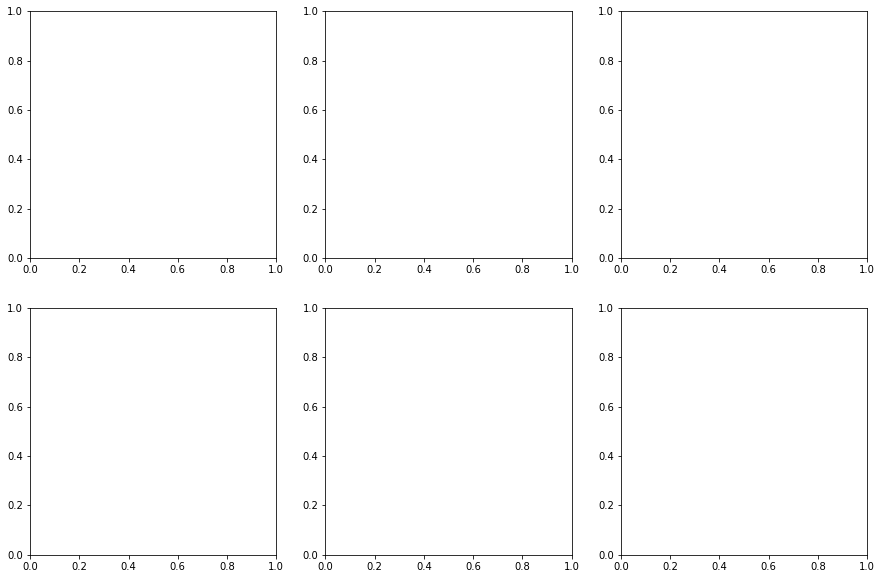

In [53]:
fig, axes = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)

In [45]:
data_subset = data[['sulphates', 'alcohol']]

In [79]:
sigsq = .9
Aisq = np.power(data_subset['sulphates'], 2) + np.power(data_subset['alcohol'], 2)
Aisq_arr = Aisq.to_numpy()
Dotprod = data_subset.dot(data_subset.T)

distmat = - repmat(Aisq_arr, 4898, 1) - repmat(Aisq_arr.reshape(-1,1), 1, 4898)  + 2*Dotprod
Afast = np.exp(distmat / (2*sigsq))
A = Afast - np.diag(np.diag(Afast))

ax = axes[0,0]
im = ax.imshow(A, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax)

In [78]:
D = np.diag(np.sum(A.T, axis=0))
L = np.linalg.inv(np.sqrt(D)).dot(A).dot(np.linalg.inv(np.sqrt(D)))
ax = axes[0,1]
im = ax.imshow(L, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax)

In [76]:
di, X = np.linalg.eig(L)
Xsort, Dsort = eigsort(X,di)
Xuse = Xsort[:, :2]
ax = axes[1,0]
im = ax.imshow(Xuse, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax)

<ipython-input-63-8fba814e3dde>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:, i] = V[:, index[i]]


In [77]:
Xsq = np.multiply(Xuse, Xuse)
divmat = repmat(np.sqrt(np.sum(Xsq.T, axis=0)).reshape(-1,1), 1, 2)
Y = np.divide(Xuse, divmat)
ax = axes[1,1]
im = ax.imshow(Y, extent=[0, 1, 0, 1])
fig.colorbar(im, ax=ax)

In [73]:
# step 5/6
kmeans = KMeans(n_clusters=2).fit(Y)
kk = kmeans.labels_
print(kk)
c1 = np.argwhere(kk == 0)
c2 = np.argwhere(kk == 1)
print(c1)
print(c2)
# ax = axes[1,2]
# ax.scatter(data_subset[c1][:,0][:,0], data_subset[c1][:,0][:,1], edgecolor='c', marker='o', facecolor='none', s=100)
# ax.scatter(data_subset[c2][:,0][:,0], data_subset[c2][:,0][:,1], edgecolor='m', marker='o', facecolor='none', s=100)
# ax.set_title('with spectral clustering')
# fig

[0 0 0 ... 0 1 1]
[[   0]
 [   1]
 [   2]
 ...
 [4892]
 [4894]
 [4895]]
[[   9]
 [  10]
 [  12]
 ...
 [4893]
 [4896]
 [4897]]


In [82]:
import hdbscan
import time
from sklearn import datasets
from sklearn.manifold import TSNE

In [5]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(data)

HDBSCAN(gen_min_span_tree=True)

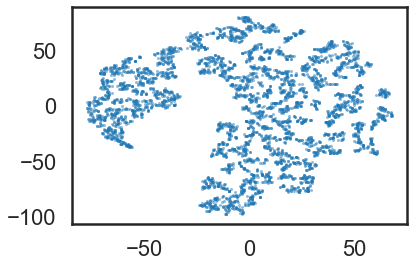

In [104]:
projection = TSNE().fit_transform(data)
plt.scatter(*projection.T, s=1, alpha=0.5)

60


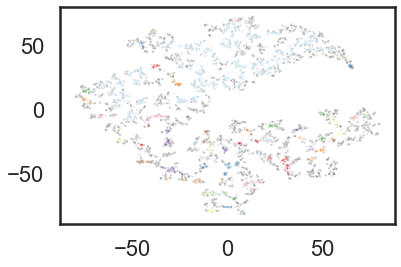

In [103]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=7, prediction_data=True).fit(data)
color_palette = sns.color_palette('Paired', clusterer.labels_.max() + 1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=4, linewidth=0, c=cluster_member_colors, alpha=0.25)